# ML - Problem Set 1: Predicting Income

Un modelo de predicción de ingresos podría ayudar a detectar casos de fraude que podrían conducir a la reducción de la evasion impositiva. Además, un modelo de predicción de ingresos puede ayudar a identificar a las personas y familias vulnerables que pueden necesitar más ayuda.

Para ello, vamos a extraer información del siguiente [sitio](https://ignaciomsarmiento.github.io/GEIH2018_sample/). Este contiene datos de Bogotá del “Informe de Medicina de Pobreza Monetaria y Desigualdad” de 2018 que toma información del GEIH.

El objetivo principal es construir un modelo de salarios horarios individuales

\begin{equation}
w = f(X) + u \tag{1}
\end{equation}

donde $w$ es el salario por hora y $X$ es una matriz que incluye posibles variables explicativas/predictores. En este conjunto de problemas, nos centraremos en $f(X) = X \beta$.

## 1 Extraccion de datos

In [ ]:
# ----------------------------------------------------------------------
# Importar librerías
# ----------------------------------------------------------------------

# Web scraping
import requests
from bs4 import BeautifulSoup

# Análisis y manipulación de datos
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneOut

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Otros
import re

In [ ]:
# ----------------------------------------------------------------------
# Adquisición de datos
# ----------------------------------------------------------------------
base_url = "https://ignaciomsarmiento.github.io/GEIH2018_sample/pages/geih_page_{}.html"
all_data = []

# Iterar sobre las 10 páginas
for i in range(1, 11):
    url = base_url.format(i)
    try:
        # Realizar la solicitud HTTP
        response = requests.get(url)
        response.raise_for_status()  # Levantar error si la solicitud falla

        # Parsear el contenido HTML
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extraer la tabla de la página
        table = soup.find('table')
        if table:
            # Extraer encabezados
            headers = [th.text.strip() for th in table.find_all('th')]

            # Extraer filas
            rows = [
                [cell.text.strip() for cell in row.find_all('td')]
                for row in table.find_all('tr')[1:]  # Excluir encabezado
            ]

            # Crear un DataFrame para la página actual
            if rows:  # Solo agregar si hay datos
                df = pd.DataFrame(rows, columns=headers)
                all_data.append(df)
                print(f"Página {i} procesada correctamente.")
            else:
                print(f"Página {i}: No se encontraron filas en la tabla.")
        else:
            print(f"Página {i}: No se encontró tabla.")
    except Exception as e:
        print(f"Error procesando la página {i}: {e}")

# Concatenar todos los DataFrames en uno solo
if all_data:  # Solo continuar si hay datos
    final_data = pd.concat(all_data, ignore_index=True)

    # Guardar en un archivo CSV
    final_data.to_csv("geih_2018_bogota.csv", index=False, encoding='utf-8')
    print("Datos guardados en 'geih_2018_bogota.csv'.")
else:
    print("No se encontraron datos para guardar.")

## 2. Carga de datos y filtrado

In [ ]:
# ----------------------------------------------------------------------
# Cargar y filtrar datos
# ----------------------------------------------------------------------

# Cargar datos desde el archivo CSV
final_data = pd.read_csv("geih_2018_bogota.csv")

# Convertir columnas relevantes a numérico y manejar errores
final_data['age'] = pd.to_numeric(final_data['age'], errors='coerce')
final_data['ocu'] = pd.to_numeric(final_data['ocu'], errors='coerce')

# Resumen inicial de valores faltantes (opcional, para depuración)
print("\nValores faltantes antes de eliminar:")
print(final_data[['age', 'ocu']].isnull().sum())

# Eliminar valores faltantes en las columnas necesarias
final_data = final_data.dropna(subset=['age', 'ocu'])

# Filtrar personas mayores de 18 años y ocupadas
filtered_data = final_data[
    (final_data['age'] > 18) & (final_data['ocu'] == 1)
].copy()

# Mostrar el número de filas restantes
print(f"\nNúmero de filas después del filtrado: {len(filtered_data)}")


Valores faltantes antes de eliminar:
age    0
ocu    0
dtype: int64

Número de filas después del filtrado: 16397


## 3. Limpiar datos y completar

In [ ]:
# ----------------------------------------------------------------------
# Manejar datos faltantes y ajustar salario mensual
# ----------------------------------------------------------------------

# Convertir 'y_salary_m' (salario mensual) a numérico
filtered_data['y_salary_m'] = pd.to_numeric(filtered_data['y_salary_m'], errors='coerce')

# Inicializar y_salary_m_c
y_salary_m_c = filtered_data['y_salary_m'].copy()

# Operaciones de ajuste del salario
operaciones_resta = [
    ('P6510', 'P6510s2'),
    ('P6580', 'P6580s2'),
    ('P6585s1', 'P6585s1a1'),
    ('P6585s2', 'P6585s2a1'),
    ('P6585s3', 'P6585s3a1'),
    ('P6585s4', 'P6585s4a1')
]

operaciones_suma = [
    ('P6590', 'P6590s1'),
    ('P6600', 'P6600s1')
]

# Aplicar operaciones de resta
for col_flag, col_value in operaciones_resta:
    if col_flag in filtered_data.columns and col_value in filtered_data.columns:
        y_salary_m_c.loc[
            (filtered_data[col_flag] == 1) & (filtered_data[col_value].notnull())
        ] -= filtered_data[col_value]

# Aplicar operaciones de suma
for col_flag, col_value in operaciones_suma:
    if col_flag in filtered_data.columns and col_value in filtered_data.columns:
        y_salary_m_c.loc[filtered_data[col_flag] == 1] += filtered_data[col_value]

# Imputar salario nulo o cero con la mediana
filtered_data['y_salary_m_c'] = SimpleImputer(strategy='median').fit_transform(
    y_salary_m_c.values.reshape(-1, 1)
)

# Identificar columnas numéricas y categóricas
numeric_columns = filtered_data.select_dtypes(include=['number']).columns
categorical_columns = filtered_data.select_dtypes(exclude=['number']).columns

# Eliminar columnas numéricas completamente nulas antes de imputar
numeric_data = filtered_data[numeric_columns].dropna(axis=1, how='all')

# Imputación de valores faltantes en columnas numéricas (mediana)
numeric_data_imputed = pd.DataFrame(
    SimpleImputer(strategy='median').fit_transform(numeric_data),
    columns=numeric_data.columns
)

# Imputación de valores faltantes en columnas categóricas (moda)
categorical_data_imputed = pd.DataFrame(
    SimpleImputer(strategy='most_frequent').fit_transform(filtered_data[categorical_columns]),
    columns=categorical_columns
)

# Reunir datos numéricos y categóricos imputados
filtered_data_cleaned = pd.concat([numeric_data_imputed, categorical_data_imputed], axis=1)

## 4. Precedir salarios

In [ ]:
# ----------------------------------------------------------------------
# Modelado y evaluación
# ----------------------------------------------------------------------

# Convertir las variables categóricas en variables dummy (one-hot encoding)
X = filtered_data_cleaned.drop(columns=['y_salary_m'])  # 'y_salary_m' es el objetivo
y = filtered_data_cleaned['y_salary_m']

# Aplicar One-Hot Encoding antes del muestreo
X = pd.get_dummies(X, drop_first=True)

# Validar las dimensiones después del encoding
print(f"Dimensiones de X después del One-Hot Encoding: {X.shape}")

# Seleccionar una muestra del 1% para procesamiento rápido
data_sample = X.join(y).sample(frac=0.01, random_state=123)
X_sample = data_sample.drop(columns=['y_salary_m'])
y_sample = data_sample['y_salary_m']

# Confirmar el tamaño de la muestra
print(f"Dimensiones de la muestra: X={X_sample.shape}, y={y_sample.shape}")

Dimensiones de X después del One-Hot Encoding: (16397, 165)
Dimensiones de la muestra: X=(164, 165), y=(164,)


In [ ]:
# ----------------------------------------------------------------------
# Modelado y ajuste de modelos incrementales
# ----------------------------------------------------------------------

# Lista de variables a considerar
variables = ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex', 'formal',
             'cuentaPropia', 'college', 'p6500', 'informal', "microEmpresa", "depto", "relab"]

# Crear un diccionario para almacenar los modelos y las variables asociadas
models = {}
for i in range(1, len(variables) + 1):
    nombre_modelo = f"modelo{i}"
    variables_modelo = variables[:i]  # Incrementar el conjunto de variables
    models[nombre_modelo] = {
        'pipeline': Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('reg', LinearRegression())
        ]),
        'variables': variables_modelo  # Guardar las variables usadas en este modelo
    }

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Ajustar cada modelo con los datos de entrenamiento
for nombre_modelo, model_info in models.items():
    # Seleccionar las columnas relevantes para el modelo actual
    columnas_modelo = model_info['variables']
    pipeline = model_info['pipeline']

    # Ajustar el modelo
    try:
        pipeline.fit(X_train[columnas_modelo], y_train)
        print(f"Modelo {nombre_modelo} ajustado con las variables: {columnas_modelo}")
    except Exception as e:
        print(f"Error al ajustar el modelo {nombre_modelo}: {e}")

Modelo modelo1 ajustado con las variables: ['maxEducLevel']
Modelo modelo2 ajustado con las variables: ['maxEducLevel', 'age']
Modelo modelo3 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm']
Modelo modelo4 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1']
Modelo modelo5 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex']
Modelo modelo6 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex', 'formal']
Modelo modelo7 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex', 'formal', 'cuentaPropia']
Modelo modelo8 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex', 'formal', 'cuentaPropia', 'college']
Modelo modelo9 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex', 'formal', 'cuentaPropia', 'college', 'p6500']
Modelo modelo10 ajustado con las variables: ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 's

## 5. Evaluacion predictiva

modelo1 ajustado. RMSE: 1533803.21
modelo2 ajustado. RMSE: 1504771.77
modelo3 ajustado. RMSE: 1418039.34
modelo4 ajustado. RMSE: 1310586.27
modelo5 ajustado. RMSE: 1304122.11
modelo6 ajustado. RMSE: 1301236.67
modelo7 ajustado. RMSE: 1264993.48
modelo8 ajustado. RMSE: 1260595.78
modelo9 ajustado. RMSE: 161812.23
modelo10 ajustado. RMSE: 175593.52
modelo11 ajustado. RMSE: 198927.54
modelo12 ajustado. RMSE: 160511.68
modelo13 ajustado. RMSE: 155288.09

Resultados de RMSE para cada modelo:
      Modelo          RMSE
12  modelo13  1.552881e+05
11  modelo12  1.605117e+05
8    modelo9  1.618122e+05
9   modelo10  1.755935e+05
10  modelo11  1.989275e+05
7    modelo8  1.260596e+06
6    modelo7  1.264993e+06
5    modelo6  1.301237e+06
4    modelo5  1.304122e+06
3    modelo4  1.310586e+06
2    modelo3  1.418039e+06
1    modelo2  1.504772e+06
0    modelo1  1.533803e+06


<ipython-input-6-bc218783b898>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Modelo', data=results_df, palette="viridis")


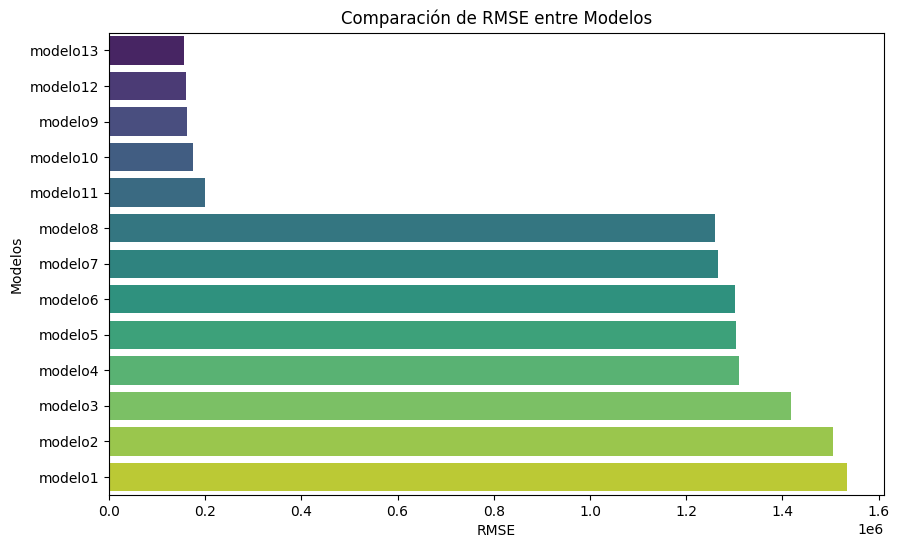

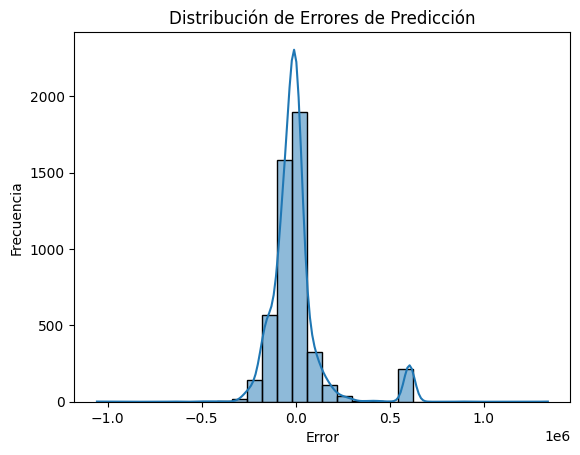

In [ ]:
# ----------------------------------------------------------------------
# Lista de variables y modelos incrementales
# ----------------------------------------------------------------------

# Lista de variables a considerar
variables = ['maxEducLevel', 'age', 'sizeFirm', 'estrato1', 'sex', 'formal',
             'cuentaPropia', 'college', 'p6500', 'informal', "microEmpresa", "depto", "relab"]

# Crear un diccionario para almacenar los modelos y sus variables
models = {}
for i in range(1, len(variables) + 1):
    nombre_modelo = f"modelo{i}"
    variables_modelo = variables[:i]  # Incrementar el conjunto de variables
    models[nombre_modelo] = {
        'pipeline': Pipeline([
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('reg', LinearRegression())
        ]),
        'variables': variables_modelo  # Guardar las variables asociadas
    }

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# ----------------------------------------------------------------------
# Función para evaluar modelos
# ----------------------------------------------------------------------
def evaluar_modelos(models, X_train, X_test, y_train, y_test):
    resultados = []
    for nombre_modelo, model_info in models.items():
        pipeline = model_info['pipeline']
        columnas_modelo = model_info['variables']

        try:
            # Ajustar el modelo
            pipeline.fit(X_train[columnas_modelo], y_train)
            # Realizar predicciones
            y_pred = pipeline.predict(X_test[columnas_modelo])
            # Calcular RMSE
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            resultados.append({'Modelo': nombre_modelo, 'Variables': columnas_modelo, 'RMSE': rmse})
            print(f"{nombre_modelo} ajustado. RMSE: {rmse:.2f}")
        except Exception as e:
            print(f"Error con el modelo {nombre_modelo}: {e}")
    return pd.DataFrame(resultados)

# Evaluar los modelos
results_df = evaluar_modelos(models, X_train, X_test, y_train, y_test)

# ----------------------------------------------------------------------
# Visualización y análisis de resultados
# ----------------------------------------------------------------------

# Mostrar resultados ordenados por RMSE
results_df = results_df.sort_values(by='RMSE')
print("\nResultados de RMSE para cada modelo:")
print(results_df[['Modelo', 'RMSE']])

# Visualización comparativa del RMSE
plt.figure(figsize=(10, 6))
sns.barplot(x='RMSE', y='Modelo', data=results_df, palette="viridis")
plt.title('Comparación de RMSE entre Modelos')
plt.xlabel('RMSE')
plt.ylabel('Modelos')
plt.show()

# Mejor modelo y análisis de errores
best_model_name = results_df.iloc[0]['Modelo']
best_model_info = models[best_model_name]
best_pipeline = best_model_info['pipeline']
best_columns = best_model_info['variables']

# Calcular errores de predicción para el mejor modelo
errors = y_test - best_pipeline.predict(X_test[best_columns])

# Visualización de errores
sns.histplot(errors, kde=True, bins=30)
plt.title('Distribución de Errores de Predicción')
plt.xlabel('Error')
plt.ylabel('Frecuencia')
plt.show()

## 6. Validacion cruzada


Realizando LOOCV para modelo13 usando el 1% de la muestra...
modelo13: RMSE (LOOCV con 1% de la muestra) = 14006890.87

Realizando LOOCV para modelo12 usando el 1% de la muestra...
modelo12: RMSE (LOOCV con 1% de la muestra) = 17302211.55

Comparación de RMSE entre LOOCV y Validation Set:
     Modelo  RMSE (Validation Set)  RMSE (LOOCV)
0  modelo13          155288.086509  1.400689e+07
1  modelo12          160511.680380  1.730221e+07


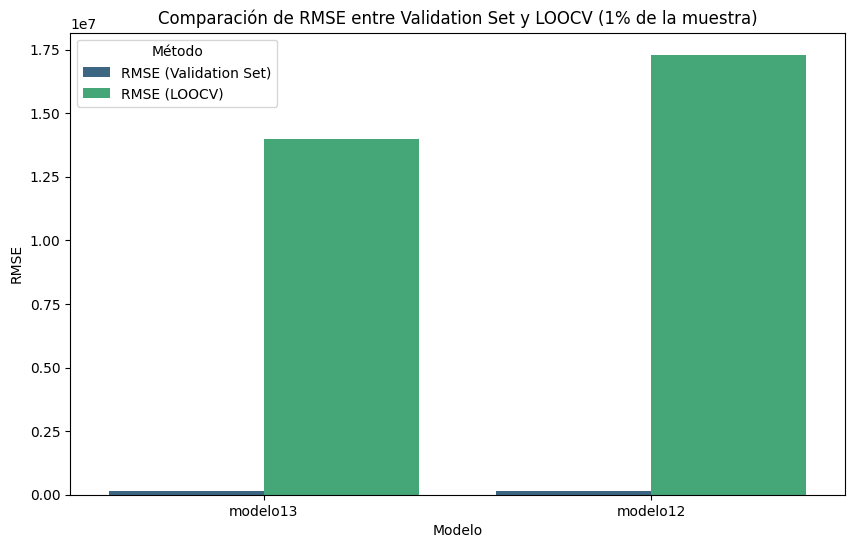

In [ ]:
# ----------------------------------------------------------------------
# LOOCV para los dos mejores modelos
# ----------------------------------------------------------------------

mejores_modelos = results_df.head(2)['Modelo'].tolist()  # Ordenados previamente por RMSE

# Tomar una muestra del 1% del conjunto de entrenamiento
X_train_sample = X_train.sample(frac=0.01, random_state=123)
y_train_sample = y_train.loc[X_train_sample.index]

# Diccionario para almacenar resultados de LOOCV
loocv_results = {}

# Realizar LOOCV para los dos mejores modelos
for nombre_modelo in mejores_modelos:
    # Obtener el pipeline y las variables del modelo
    model_info = models[nombre_modelo]
    pipeline = model_info['pipeline']
    variables = model_info['variables']

    # Inicializar LOOCV
    loo = LeaveOneOut()
    y_pred_loocv = []

    print(f"\nRealizando LOOCV para {nombre_modelo} usando el 1% de la muestra...")

    # LOOCV: Iterar sobre cada observación como conjunto de prueba
    for train_index, test_index in loo.split(X_train_sample):
        # Crear los conjuntos de entrenamiento y prueba
        X_train_loo, X_test_loo = X_train_sample.iloc[train_index][variables], X_train_sample.iloc[test_index][variables]
        y_train_loo, y_test_loo = y_train_sample.iloc[train_index], y_train_sample.iloc[test_index]

        # Entrenar el modelo y predecir
        pipeline.fit(X_train_loo, y_train_loo)
        y_pred_loocv.append(pipeline.predict(X_test_loo)[0])

    # Calcular RMSE de LOOCV
    rmse_loocv = np.sqrt(mean_squared_error(y_train_sample, y_pred_loocv))
    loocv_results[nombre_modelo] = rmse_loocv
    print(f"{nombre_modelo}: RMSE (LOOCV con 1% de la muestra) = {rmse_loocv:.2f}")

# Convertir resultados de LOOCV en un DataFrame
loocv_df = pd.DataFrame(loocv_results.items(), columns=['Modelo', 'RMSE (LOOCV)'])

# ----------------------------------------------------------------------
# Comparación de resultados con el conjunto de validación
# ----------------------------------------------------------------------

# Crear un DataFrame para comparar resultados
comparacion_df = results_df[results_df['Modelo'].isin(mejores_modelos)][['Modelo', 'RMSE']].merge(
    loocv_df, on='Modelo', how='inner'
)
comparacion_df.rename(columns={'RMSE': 'RMSE (Validation Set)'}, inplace=True)

# Mostrar resultados
print("\nComparación de RMSE entre LOOCV y Validation Set:")
print(comparacion_df)

# ----------------------------------------------------------------------
# Visualización de la comparación
# ----------------------------------------------------------------------
comparacion_df_melted = comparacion_df.melt(id_vars='Modelo', value_vars=['RMSE (Validation Set)', 'RMSE (LOOCV)'],
                                            var_name='Método', value_name='RMSE')

plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='RMSE', hue='Método', data=comparacion_df_melted, palette="viridis")
plt.title('Comparación de RMSE entre Validation Set y LOOCV (1% de la muestra)')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.legend(title='Método')
plt.show()

Realizando LOOCV para modelo13 (1% de la muestra)...
modelo13: RMSE (LOOCV, 1% de la muestra) = 869465.34
Realizando LOOCV para modelo12 (1% de la muestra)...
modelo12: RMSE (LOOCV, 1% de la muestra) = 772898.56

Resultados de RMSE (Validación y LOOCV):
      Modelo                                          Variables          RMSE  \
0   modelo13  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.552881e+05   
1   modelo12  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.605117e+05   
2    modelo9  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.618122e+05   
3   modelo10  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.755935e+05   
4   modelo11  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.989275e+05   
5    modelo8  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.260596e+06   
6    modelo7  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.264993e+06   
7    modelo6  [maxEducLevel, age, sizeFirm, estrato1, sex, f...  1.301237e+06   
8    modelo5     

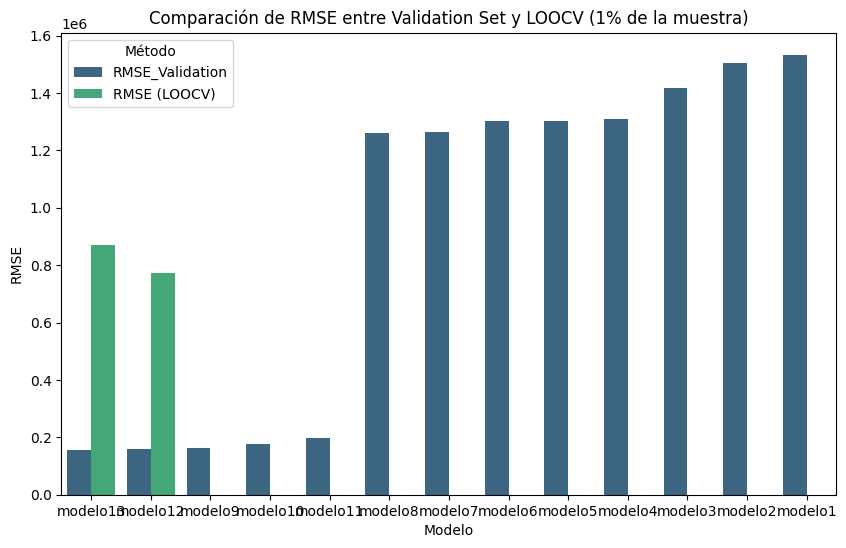

In [ ]:
# ----------------------------------------------------------------------
# Función para realizar LOOCV
# ----------------------------------------------------------------------
def realizar_loocv(model, X, y):
    """
    Realiza Leave-One-Out Cross-Validation (LOOCV) para un modelo dado.
    """
    loo = LeaveOneOut()
    y_pred_loocv = []

    # Iterar sobre cada observación como conjunto de prueba
    for train_index, test_index in loo.split(X):
        X_train_loo, X_test_loo = X.iloc[train_index], X.iloc[test_index]
        y_train_loo, y_test_loo = y.iloc[train_index], y.iloc[test_index]

        # Ajustar el modelo y predecir
        model.fit(X_train_loo, y_train_loo)
        y_pred_loocv.append(model.predict(X_test_loo)[0])  # Obtener la predicción individual

    # Calcular RMSE para LOOCV
    rmse_loocv = np.sqrt(mean_squared_error(y, y_pred_loocv))
    return rmse_loocv

# ----------------------------------------------------------------------
# Evaluar los dos mejores modelos con LOOCV (1% de la muestra)
# ----------------------------------------------------------------------

# Seleccionar los dos mejores modelos
mejores_modelos = results_df.head(2)['Modelo'].tolist()

# Tomar una muestra del 1% de los datos
X_sample = X.sample(frac=0.01, random_state=123)
y_sample = y.loc[X_sample.index]

# Diccionario para almacenar resultados de LOOCV
loocv_results = {}

for nombre_modelo in mejores_modelos:
    model_info = models[nombre_modelo]
    pipeline = model_info['pipeline']
    variables = model_info['variables']  # Variables relevantes del modelo

    # Filtrar la muestra según las variables del modelo
    X_data_sample = X_sample[variables]

    try:
        print(f"Realizando LOOCV para {nombre_modelo} (1% de la muestra)...")
        rmse_loocv = realizar_loocv(pipeline, X_data_sample, y_sample)
        loocv_results[nombre_modelo] = rmse_loocv
        print(f"{nombre_modelo}: RMSE (LOOCV, 1% de la muestra) = {rmse_loocv:.2f}")
    except Exception as e:
        print(f"Error con el modelo {nombre_modelo}: {e}")

# Convertir resultados de LOOCV en un DataFrame
loocv_df = pd.DataFrame(loocv_results.items(), columns=['Modelo', 'RMSE (LOOCV)'])

# ----------------------------------------------------------------------
# Combinar y comparar resultados
# ----------------------------------------------------------------------

# Unir los resultados de LOOCV con los resultados previos
resultados_combinados = pd.merge(results_df, loocv_df, on='Modelo', how='left')

# Renombrar temporalmente la columna 'RMSE' para evitar conflictos con el melt
resultados_combinados_renamed = resultados_combinados.rename(columns={'RMSE': 'RMSE_Validation'})

# Realizar el melt
resultados_combinados_melted = resultados_combinados_renamed.melt(
    id_vars='Modelo',
    value_vars=['RMSE_Validation', 'RMSE (LOOCV)'],
    var_name='Método',
    value_name='RMSE'
)

# Mostrar los resultados combinados
print("\nResultados de RMSE (Validación y LOOCV):")
print(resultados_combinados)

# ----------------------------------------------------------------------
# Visualización
# ----------------------------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(x='Modelo', y='RMSE', hue='Método', data=resultados_combinados_melted, palette="viridis")
plt.title('Comparación de RMSE entre Validation Set y LOOCV (1% de la muestra)')
plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.legend(title='Método')
plt.show()

## Resultados

El modelo es que explica el salario: $\hat{y}$ es:

\begin{equation}
\hat{y} = \beta_0 + \sum_{i=1}^{13} \beta_i x_i + \sum_{i=1}^{13} \sum_{j=i}^{13} \beta_{ij} x_i x_j + \sum_{i=1}^{13} \sum_{j=i}^{13} \sum_{k=j}^{13} \beta_{ijk} x_i x_j x_k
\end{equation}

donde:

$x_1=maxEducLevel$: Nivel máximo de educación alcanzado.

$x_2=age$: Edad del trabajador.

$x_3=sizeFirm$: Tamaño de la empresa.

$x_4=estrato1$: Estrato socioeconómico.

$x_5=sex$: Sexo del trabajador (1=Hombre, 0=Mujer).

$x_6=formal$: Empleo formal (1=Sí, 0=No).

$x_7=cuentaPropia$: Trabajador por cuenta propia (1=Sí, 0=No).

$x_8=college$: Tiene título universitario (1=Sí, 0=No).

$x_9=p6500$: Tipo de vínculo laboral.

$x_{10}=informal$: Empleo informal (1=Sí, 0=No).

$x_{11}=microEmpresa$: Microempresa (1=Sí, 0=No).

$x_{12}=depto$: Departamento de residencia.

$x_{13}=relab$: Relación laboral.

In [14]:
# Extraer coeficientes del modelo 13
modelo_13 = models['modelo13']['pipeline']
variables_modelo_13 = models['modelo13']['variables']

# Generar características polinómicas
poly_features = modelo_13.named_steps['poly']
X_train_poly = poly_features.fit_transform(X_train[variables_modelo_13])

# Extraer coeficientes e intercepto
reg = modelo_13.named_steps['reg']
coeficientes = reg.coef_
intercepto = reg.intercept_

# Nombres de las variables polinómicas
nombres_features = poly_features.get_feature_names_out(variables_modelo_13)

# Mostrar coeficientes con las variables asociadas
coeficientes_df = pd.DataFrame({'Variable': nombres_features, 'Coeficiente': coeficientes})
print(coeficientes_df)

                 Variable   Coeficiente
0            maxEducLevel  1.191329e-02
1                     age -3.499140e-05
2                sizeFirm  3.804498e-06
3                estrato1 -2.820316e-07
4                     sex  7.503033e-07
..                    ...           ...
554  microEmpresa relab^2 -1.258272e-05
555               depto^3  0.000000e+00
556         depto^2 relab -3.604683e-04
557         depto relab^2 -1.310324e-04
558               relab^3 -3.878255e-05

[559 rows x 2 columns]
